# Predicting Blight buildings in Detroit

Blighted abandoned property can be a danger to the public and lead to an increase in crime. The effect of urban disorder and vandalism triggers additional crime and anti-social behavior. Blight has a negative effect on surrounding property values, which not only hurts adjacent property owners but reduces local property tax revenue, in turn driving more neighbors away.

In this project, I have built a model to predict blight risk buildings in advance in Detroit city. For this, I used four datasets:

- detroit-blight-violations.csv : Each record is a blight violation incident.
<br>
- detroit-demolition-permits.tsv: Each record represents a permit for a demolition.
<br>
- detroit-311.csv: Each record represents a 311 call, typically a complaint
<br>
- detroit-crime.csv: Each record represents a criminial incident.
<br>

These public datasets are taken from http://data.detroitmi.gov. For each incident type, the location is included as a latitude, longitude pair and various timestamps are included.


In [1]:
#import all the required packagaes and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import time
import random
import math
import ast
from osgeo import ogr
from geopy import distance
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.neighbors import BallTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

Let\`s look at the shape of the detroit city to know it\`s boundaries. The shape file is taken from <br>
https://data.detroitmi.gov/Government/City-of-Detroit-Boundary/vqqa-wgrj/data

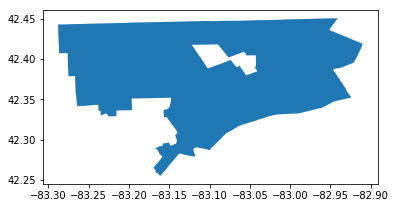

In [2]:
#The below code can be used if shapefile contains non-UTF characters that causes the fiona.call() to fail.
#Code in this cell is taken from 
#https://stackoverflow.com/questions/47243879/brecode-from-ansi-1252-to-utf-8-failed-with-the-error-invalid-argument-geo/47276340#47276340

driver = ogr.GetDriverByName("ESRI Shapefile")
ds = driver.Open("geo_export_eae0f2ac-f5a0-48ec-b30e-fa7e00f93f16.shp", 0) #open the shapefile and get its layer
layer = ds.GetLayer()

#Create a new shapefile to convert
ds2 = driver.CreateDataSource('1.shp')
#create a Polygon layer, as the Shapefile
layer2 = ds2.CreateLayer('', None, ogr.wkbPolygon)
#iterate over all features of the original shapefile
for feature in layer:
    #and create a new feature on the converted shapefile with those features
    layer2.CreateFeature(feature)
ds = layer = ds2 = layer2 = None

detroit = gpd.read_file("1.shp")
detroit.plot()

The above plot shows the shape of detroit city. Treating it as a rectangle for convenience, we can say that any point in the city should satisfy the conditions:

42.25 < latitude < 42.45 <br> -83.3 < longitude < -82.9 <br>

We can use the above inequalities to examine and if necessary eliminate outliers in the incident data.

There are 4 datasets of incidents.

1) detroit 311 calls<br>2) detroit blight violations<br>3) detroit crime data<br>4) detroit demolition permits.

Each entry in these datasets correspond to an incident at a particular location.  

Let\`s combine all these datasets into a single dataset containing all 4 types of incidents with columns incident id, latitude, longitude, address. This makes it easier to work with the data further. 

I have divided this project into the below sections sequentially.

1) Preprocessing the data<br>
2) Feature Engineering<br>
3) Model evaluation and interpretation<br>

## 1) Preprocessing the data

### Detroit 311 calls data 

First, Let\`s look at detroit 311 calls data.

In [3]:
data_311 = pd.read_csv("./data/detroit-311.csv")

In [4]:
length_311 = len(data_311)
start = 0
end = length_311
data_311["record_id"] = range(start, end) #adding new column record_id
data_311.tail(2)

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,record_id
19678,1969198,City of Detroit,DPW - Debris Removal,Acknowledged,NaN,2,NaN,10/12/2015 04:26:58 PM,10/12/2015 10:24:03 AM,10/14/2015 03:24:31 PM,"10611 Lanark Detroit, Michigan",42.423851,-82.934012,"(42.423851, -82.934012)",NaN,19678
19679,1969139,City of Detroit,DPW - Debris Removal,Acknowledged,NaN,2,NaN,10/12/2015 04:26:58 PM,10/12/2015 09:49:29 AM,10/14/2015 03:23:41 PM,"10127 Britain Ave Detroit, Michigan",42.418861,-82.939274,"(42.418861, -82.9392736)",NaN,19679


We will need the columns lat, lng, and address from the 311 calls data.
Incase there are any empty values in these columns, we will mark those entries as NaN and drop the rows corresponding to those entries.

In [5]:
data_311["lat"] = data_311["lat"].replace('', np.nan)
data_311["lng"] = data_311["lng"].replace('', np.nan)
data_311["address"] = data_311["address"].replace('', np.nan)
data_311.dropna(subset = ["lat", "lng", "address"], inplace = True)

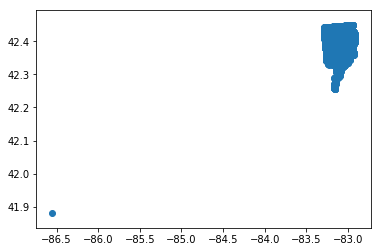

In [6]:
plt.scatter(data_311["lng"], data_311["lat"])
plt.show()

Let\`s look at all outliers (whose lat and long are beyond the boundaries). From the above graph, we can see that there is only one outlier in the 311 calls data.

In [7]:
data_311.loc[(data_311["lat"] < 42.25) | (data_311["lat"] > 42.45) | (data_311["lng"] < -83.3) | (data_311["lng"] > -82.9)]

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,record_id
4879,1454514,City of Detroit,Running Water in a Home or Building,Archived,NaN,2,01/26/2015 09:27:39 AM,01/23/2015 02:34:45 PM,01/23/2015 02:26:59 PM,01/26/2015 09:27:39 AM,"14530 Vaughan Detroit, Michigan",41.879952,-86.550059,"(41.8799519, -86.5500592)",NaN,4879


Although the address is shown as detroit, the lat and long specified doesn\`t belong to detroit. Hence let\`s remove this outlier.

In [8]:
data_311 = data_311[~((data_311["lat"] < 42.25) | (data_311["lat"] > 42.45) | (data_311["lng"] < -83.3) | (data_311["lng"] > -82.9))]

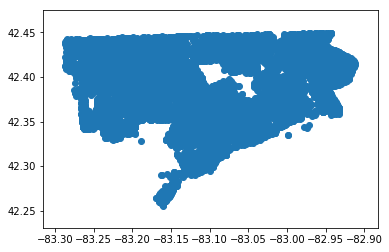

In [9]:
plt.scatter(data_311["lng"], data_311["lat"])
plt.show()

In [10]:
tempdata_311 = data_311[["record_id", "lat", "lng", "address"]]

In [11]:
tempdata_311.head()

,record_id,lat,lng,address
0,0,42.383998,-83.161039,"13120-13130 Ilene Street Detroit, MI 48238, USA"
1,1,42.440471,-83.080919,"1485 E. Outer Drive Detroit, Michigan"
2,2,42.445244,-82.962038,"15460 Eastburn Detroit, Michigan"
3,3,42.421043,-83.166194,"17541 Mendota St Detroit, Michigan"
4,4,42.402033,-83.162874,"Griggs Detroit, Michigan"


### Detroit Blight violations data

In [12]:
data_violations = pd.read_csv("./data/detroit-blight-violations.csv")

C:\Users\Mohan\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
length_violations = len(data_violations)
start = start + length_311
end = end + length_violations
data_violations["record_id"] = range(start, end)
data_violations.tail(2)

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,...,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,record_id
307802,333480,19002373DAH,Department of Public Works,"GALLERY, JOHNSON TRADING",1945,WEBB,47-42,43RD ST,QUEENS,NY,...,$50.00,$10.00,$0.00,$580.00,PAID IN FULL,0.0,0,"1945 WEBB\nDetroit, MI\n(42.385923235000064, -...","47 42 43RD ST\nQUEENS, NY 11377\n(40.745477829...",327482
307803,333236,19002453DAH,Department of Public Works,BROOKDALE INVESTMENTS INC,13100,WARREN,22443,PLYMOUTH RD,DETROIT,MI,...,$100.00,$10.00,$0.00,$1130.00,PARTIAL PAYMENT MADE,0.0,0,"13100 WARREN\nDetroit, MI\n(42.33168113800008,...","22443 PLYMOUTH RD\nDETROIT, MI 48239\n(42.3715...",327483


In [14]:
data_violations["ViolationAddress"] = data_violations["ViolationAddress"].replace('', np.nan)
data_violations.dropna(subset = ["ViolationAddress"], inplace = True)

In [15]:
data_violations["address"] = [incident.split("\n")[0] for incident in data_violations["ViolationAddress"]]
data_violations["ViolationCoordinates"] = [incident.split("\n")[-1] for incident in data_violations["ViolationAddress"]]
data_violations["ViolationLat"] = [ast.literal_eval(coordinates)[0] for coordinates in data_violations["ViolationCoordinates"]]
data_violations["ViolationLng"] = [ast.literal_eval(coordinates)[1] for coordinates in data_violations["ViolationCoordinates"]]

In [16]:
data_violations.loc[(data_violations["ViolationLat"] < 42.25) | (data_violations["ViolationLat"] > 42.45) | (data_violations["ViolationLng"] < -83.3) | (data_violations["ViolationLng"] > -82.9)]

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,...,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,record_id,address,ViolationCoordinates,ViolationLat,ViolationLng


Hence there are no coordinates outliers in the blight violations data.

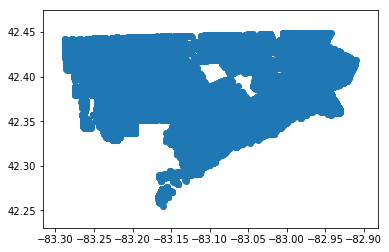

In [17]:
plt.scatter(data_violations["ViolationLng"], data_violations["ViolationLat"])
plt.show()

In [18]:
tempdata_violations = data_violations[["record_id", "ViolationLat", "ViolationLng", "address"]]

In [19]:
tempdata_violations.columns = ["record_id", "lat", "lng", "address"]

In [20]:
tempdata_violations.head()

,record_id,lat,lng,address
0,19680,42.363182,-83.091677,2566 GRAND BLVD
1,19681,42.429391,-83.220394,19014 ASHTON
2,19682,42.428707,-83.227548,18735 STAHELIN
3,19683,42.441698,-83.145018,20125 MONICA
4,19684,42.420318,-83.145328,17397 PRAIRIE


### Detroit Crime Data

In [21]:
data_crime = pd.read_csv("./data/detroit-crime.csv")

C:\Users\Mohan\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
length_crime = len(data_crime)
start = start + length_violations
end = end + length_crime
data_crime["record_id"] = range(start, end)
data_crime.tail(2)

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,LON,LAT,LOCATION,record_id
119929,4718,1904089,1.50118e+09,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - NON-FAMILY - OTHER WEAPON,13002.0,01/18/2015 12:00:00 AM,13,901.0,9.0,City Council District 3,GREENSBRIAR,5032.0,20500 GOULBURN,-82.9946,42.4477,"GOULBURN\n20500\n(42.4478, -82.9944)",447413
119930,10118,1909796,1.50205e+09,ASSAULT,INTIMIDATION,13003.0,02/04/2015 12:00:00 AM,11,710.0,7.0,City Council District 5,ELMWOOD PARK,5167.0,01600 ROBERT BRADBY DR,-83.0221,42.3454,"ROBERT BRADBY\nDR 01600\n(42.3453, -83.022)",447414


In [23]:
data_crime["LAT"] = data_crime["LAT"].replace('', np.nan)
data_crime["LON"] = data_crime["LON"].replace('', np.nan)
data_crime["ADDRESS"] = data_crime["ADDRESS"].replace('', np.nan)
data_crime.dropna(subset = ["LAT", "LON", "ADDRESS"], inplace = True)

In [24]:
data_crime.loc[(data_crime["LAT"] < 42.25) | (data_crime["LAT"] > 42.45) | (data_crime["LON"] < -83.3) | (data_crime["LON"] > -82.9)]

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,LON,LAT,LOCATION,record_id
232,63890,1964690,1506300106.1,BURGLARY,BURGLARY - UNOCCUPIED BUILDING OR OTHER STRUCTURE,22001.0,06/19/2015 12:00:00 AM,14,NaN,NaN,NaN,NaN,9.0,25500 INGLESIDE DRIVE,-83.2948,42.4691,"INGLESIDE DRIVE\n25500\n(42.4692, -83.2945)",327716
395,65660,1966486,1507040298.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,07/04/2015 12:00:00 AM,18,NaN,NaN,NaN,NaN,9.0,02700 W. GRAND BLVD,999998.9998,999999.0001,"W. GRAND BLVD\n02700\n(999998.9998, 999998.9999)",327879
617,50399,1951039,1505270075.1,OBSTRUCTING JUDICIARY,PROBATION VIOLATION,50000.0,05/27/2015 12:00:00 AM,7,NaN,NaN,NaN,NaN,1814.0,29000 MILE RD,-83.1166,42.5045,"MILE\nRD 29000\n(42.5045, -83.1164)",328101
1494,13334,1913244,1502150170.1,TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED,WARRANTS - CORPORATE SUMMONS,89004.0,02/15/2015 12:00:00 AM,16,NaN,NaN,NaN,NaN,2584.0,00 EASTPOINT POLICE DEPARTMENT,-82.9559,42.4652,"00 EASTPOINT POLICE DEPARTMENT\n(42.4651, -82....",328978
1570,22215,1922418,1503150109.1,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - NON-FAMILY - OTHER WEAPON,13002.0,03/15/2015 12:00:00 AM,8,NaN,NaN,NaN,NaN,9.0,00 UNKNOWN,999998.9999,999998.9999,"00 UNKNOWN\n(999999, 999999.0001)",329054
1872,53727,1954403,1506040091.1,TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS,MISCELLANEOUS - GENERAL ASSISTANCE,99008.0,06/04/2015 12:00:00 AM,8,NaN,NaN,NaN,NaN,5770.0,00 SOUTHFIELD ROAD / ELECTRIC STREET,-83.1748,42.2496,00 SOUTHFIELD ROAD / ELECTRIC STREET\n(42.2496...,329356
2004,6404,1905961,1501230264.1,TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED,WARRANTS - CORPORATE SUMMONS,89004.0,01/23/2015 12:00:00 AM,20,NaN,NaN,NaN,NaN,5761.0,11100 OLIVE,-83.3983,42.2210,"OLIVE\n11100\n(42.2208, -83.3983)",329488
2264,50479,1951140,1505270170.1,STOLEN VEHICLE,STOLEN (OTHER),24001.0,05/13/2015 12:00:00 AM,20,NaN,NaN,NaN,NaN,9.0,00 BEAUBIEN / KING,999998.9999,999999.0000,"00 BEAUBIEN / KING\n(999998.9999, 999999)",329748
3016,44375,1944927,1505120005.1,STOLEN VEHICLE,VEHICLE THEFT,24001.0,05/12/2015 12:00:00 AM,0,NaN,NaN,NaN,NaN,9.0,00 TURNER/WADE,999998.9999,999998.9998,"00 TURNER/WADE\n(999999, 999999.0001)",330500
3191,14549,1914599,1502190259.1,TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED,WARRANTS - CORPORATE SUMMONS,89004.0,02/19/2015 12:00:00 AM,18,NaN,NaN,NaN,NaN,9.0,00 DEARBORN HTS POLICE DEPT,999999.0000,999998.9999,"00 DEARBORN HTS POLICE DEPT\n(999999, 999998.9...",330675


So, we have 509 outliers as their coordinates doesn\`t fall in the detroit region. Let\`s remove them.

In [25]:
data_crime = data_crime[~((data_crime["LAT"] < 42.25) | (data_crime["LAT"] > 42.45) | (data_crime["LON"] < -83.3) | (data_crime["LON"] > -82.9))]
#print(len(data_crime))

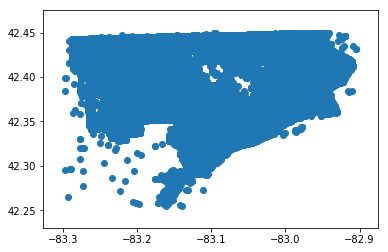

In [26]:
plt.scatter(data_crime["LON"], data_crime["LAT"])
plt.show()

In [27]:
tempdata_crime = data_crime[["record_id", "LAT", "LON", "ADDRESS"]]
tempdata_crime.columns = ["record_id", "lat", "lng", "address"]
tempdata_crime.tail()

,record_id,lat,lng,address
119926,447410,42.4452,-83.1379,20400 PICADILLY
119927,447411,42.4362,-82.9587,15600 MADDELEIN
119928,447412,42.4109,-83.2655,16500 BEAVERLAND
119929,447413,42.4477,-82.9946,20500 GOULBURN
119930,447414,42.3454,-83.0221,01600 ROBERT BRADBY DR


### Detroit permits data

In [28]:
data_permits = pd.read_table("./data/detroit-demolition-permits.tsv")

In [29]:
length_permits = len(data_permits)
start = start + length_crime
end = end + length_permits
data_permits["record_id"] = range(start, end)
data_permits.head(2)

,PERMIT_NO,PERMIT_APPLIED,PERMIT_ISSUED,PERMIT_EXPIRES,SITE_ADDRESS,BETWEEN1,PARCEL_NO,LOT_NUMBER,SUBDIVISION,CASE_TYPE,...,CONTRACTOR_ADDRESS2,CONTRACTOR_CITY,CONTRACTOR_STATE,CONTRACTOR_ZIP,CONDITION_FOR_APPROVAL,site_location,owner_location,contractor_location,geom,record_id
0,BLD2015-03955,8/28/15,8/28/15,NaN,4331 BARHAM,BETWEEN VOIGHT AND WAVENEY,21 65525-6,S15,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"4331 BARHAM\nDetroit, MI\n(42.394106, -82.9474)","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,447415
1,BLD2015-04083,8/28/15,8/28/15,NaN,9707 BESSEMORE,BETWEEN VINTON AND GRATIOT,19 2312.,40,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"9707 BESSEMORE\nDetroit, MI\n(42.395122, -83.0...","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,447416


In [30]:
data_permits["site_location"] = data_permits["site_location"].replace('', np.nan)
data_permits.dropna(subset = ["site_location"], inplace = True)
data_permits["site_coordinates"] = [incident.split("\n")[-1] for incident in data_permits["site_location"]]
data_permits["site_coordinates"] = data_permits["site_coordinates"].replace('', np.nan)
data_permits.dropna(subset = ["site_coordinates"], inplace = True)
data_permits["site_lat"] = [ast.literal_eval(coordinates)[0] for coordinates in data_permits["site_coordinates"]]
data_permits["site_lng"] = [ast.literal_eval(coordinates)[1] for coordinates in data_permits["site_coordinates"]]

In [31]:
data_permits.loc[(data_permits["site_lat"] < 42.25) | (data_permits["site_lat"] > 42.45) | (data_permits["site_lng"] < -83.3) | (data_permits["site_lng"] > -82.9)]

,PERMIT_NO,PERMIT_APPLIED,PERMIT_ISSUED,PERMIT_EXPIRES,SITE_ADDRESS,BETWEEN1,PARCEL_NO,LOT_NUMBER,SUBDIVISION,CASE_TYPE,...,CONTRACTOR_ZIP,CONDITION_FOR_APPROVAL,site_location,owner_location,contractor_location,geom,record_id,site_coordinates,site_lat,site_lng
6053,BLD2012-00282,1/18/12,1/18/12,7/18/12,67 - 69 SIBLEY,Between WOODWARD and PARK,2 592.,31-,"SUB OF PARK LOTS 77,78,79",BLD,...,48317.0,NaN,"67 69\nDETROIT, MI\n(69.000000000000057, 67.00...","26340 BELAIR\nROSEVILLE, MI 48066\n(42.4907313...","5675 AUBURN RD\nSHELBY TWP, MI 48317\n(42.6342...",NaN,453468,"(69.000000000000057, 67.000000000000057)",69.0,67.0


We have one outlier in the permits data set. Let\`s remove it.

In [32]:
data_permits = data_permits[~((data_permits["site_lat"] < 42.25) | (data_permits["site_lat"] > 42.45) | (data_permits["site_lng"] < -83.3) | (data_permits["site_lng"] > -82.9))]

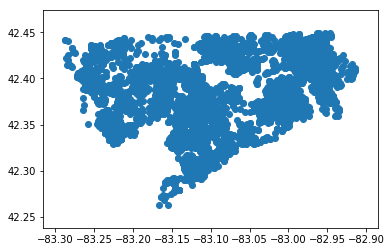

In [33]:
plt.scatter(data_permits["site_lng"], data_permits["site_lat"])
plt.show()

In [34]:
tempdata_permits = data_permits[["record_id", "site_lat", "site_lng", "SITE_ADDRESS"]]
tempdata_permits.columns = ["record_id", "lat", "lng", "address"]
tempdata_permits.head()

,record_id,lat,lng,address
0,447415,42.394106,-82.947400,4331 BARHAM
1,447416,42.395122,-83.005077,9707 BESSEMORE
2,447417,42.403220,-82.946476,5315 BERKSHIRE
3,447418,42.446640,-82.947207,16670 BRINGARD DR
4,447419,42.276956,-83.147536,1454 BEATRICE


Now that we have columns "lat", "lng", "address" from all the four data sets, let\`s concatenate them into a single data set. 

In [35]:
mergedata = [tempdata_311, tempdata_violations, tempdata_crime, tempdata_permits]

In [36]:
fulldata = pd.concat(mergedata, ignore_index = True)
fulldata.tail()

,record_id,lat,lng,address
453156,454543,42.392986,-83.109840,1678 LESLIE
453157,454544,42.406939,-83.133498,15733 MUIRLAND
453158,454545,42.372981,-82.987687,3453 BEWICK
453159,454546,42.343427,-83.214301,17630 W WARREN
453160,454547,42.371425,-82.991361,9403 SCHILLER


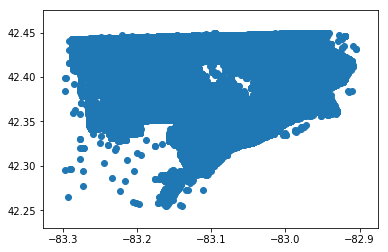

In [37]:
plt.scatter(fulldata["lng"], fulldata["lat"])
plt.show()

In [38]:
tempfulldata = fulldata
tempfulldata.set_index("record_id", inplace = True)
tempfulldata.head()

,lat,lng,address
record_id,,,
0,42.383998,-83.161039,"13120-13130 Ilene Street Detroit, MI 48238, USA"
1,42.440471,-83.080919,"1485 E. Outer Drive Detroit, Michigan"
2,42.445244,-82.962038,"15460 Eastburn Detroit, Michigan"
3,42.421043,-83.166194,"17541 Mendota St Detroit, Michigan"
4,42.402033,-83.162874,"Griggs Detroit, Michigan"


In [39]:
geocoordinates_lat = []
geocoordinates_lng = []
incidents = []
geogroups = tempfulldata.groupby(["lat", "lng"]).groups
for item in geogroups:
    geocoordinates_lat.append(item[0])
    geocoordinates_lng.append(item[1])
    incidents.append(geogroups[item].values.tolist())   

In [40]:
buildingsdata = pd.DataFrame()
buildingsdata["building_id"] = range(0, len(geocoordinates_lat))
buildingsdata["lat"] = geocoordinates_lat
buildingsdata["lng"] = geocoordinates_lng
buildingsdata["incidents"] = incidents
buildingsdata.head()

,building_id,lat,lng,incidents
0,0,42.38780,-82.990300,"[356992, 391929]"
1,1,42.27230,-83.152600,[341473]
2,2,42.39320,-83.081400,[375308]
3,3,42.35602,-83.232184,[39004]
4,4,42.34170,-83.063500,[387607]


In [41]:
deg_to_rad = math.pi/180
lat_rad = buildingsdata["lat"].apply(lambda x: deg_to_rad*x)
lng_rad = buildingsdata["lng"].apply(lambda x: deg_to_rad*x)
coordinates_rad = pd.DataFrame()
coordinates_rad["lat_rad"] = lat_rad
coordinates_rad["lng_rad"] = lng_rad
coordinates_rad.head()

,lat_rad,lng_rad
0,0.739807,-1.448454
1,0.737791,-1.451287
2,0.739901,-1.450044
3,0.739252,-1.452676
4,0.739002,-1.449732


I have used BallTree data structure to discover neighbourhood points. Check out the below links for more information on BallTree.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree
<br>
https://en.wikipedia.org/wiki/Ball_tree

In [42]:
start_time = time.time()
tree = BallTree(coordinates_rad.values, metric = "haversine")
print(time.time() - start_time)

0.346999883652


In [43]:
clusterbuildings = buildingsdata
cluster_id = [0]*len(buildingsdata)
cluster_val = 1
start_time = time.time()
for index, row in coordinates_rad.iterrows():
    ind, dist = tree.query_radius(coordinates_rad.values[[index]], r = 0.03106856/3959, return_distance = True)
    for index in ind[0]:
        if cluster_id[index] == 0:
            cluster_id[index] = cluster_val
    cluster_val = cluster_val + 1
print(time.time() - start_time)    

154.38499999


In [44]:
clusterbuildings["cluster_id"] = cluster_id
clusterbuildings.head()

,building_id,lat,lng,incidents,cluster_id
0,0,42.38780,-82.990300,"[356992, 391929]",1
1,1,42.27230,-83.152600,[341473],2
2,2,42.39320,-83.081400,[375308],3
3,3,42.35602,-83.232184,[39004],4
4,4,42.34170,-83.063500,[387607],5


In [45]:
clustergroups = clusterbuildings.groupby(["cluster_id"]).groups
clustergroups[1]

Int64Index([0, 98363, 192471, 193789], dtype='int64')

In [46]:
def geodistance(x, y):
    lat1, lng1 = x[0], x[1]
    lat2, lng2 = y[0], y[1]
    return distance.distance((lat1, lng1), (lat2, lng2)).miles

This function takes a location (lat, lng) as input and returns a building associated with that location. 

In [47]:
buildingsgeodata = buildingsdata[['lat', 'lng']].values
def associatedBuilding(location, buildingsgeodata):
    found = 0
    for i in range(0, len(buildingsgeodata)):
        if location == (buildingsgeodata[i][0], buildingsgeodata[i][1]):
            index = i
            found = 1
    if found == 0:        
        mindist = 9999999999999
        for i in range(0, len(buildingsgeodata)):
            geodist = geodistance(location, buildingsgeodata[i])
            if geodist < mindist:
                mindist = geodist
                index = i        
    return index        

## Week 3

Now that we have the buildings data, let\`s construct the training data set by associating each building with a label (blight or not blight) using the permits data.

In [48]:
data_permits.head(1)

,PERMIT_NO,PERMIT_APPLIED,PERMIT_ISSUED,PERMIT_EXPIRES,SITE_ADDRESS,BETWEEN1,PARCEL_NO,LOT_NUMBER,SUBDIVISION,CASE_TYPE,...,CONTRACTOR_ZIP,CONDITION_FOR_APPROVAL,site_location,owner_location,contractor_location,geom,record_id,site_coordinates,site_lat,site_lng
0,BLD2015-03955,8/28/15,8/28/15,NaN,4331 BARHAM,BETWEEN VOIGHT AND WAVENEY,21 65525-6,S15,NaN,BLD,...,48227.0,NaN,"4331 BARHAM\nDetroit, MI\n(42.394106, -82.9474)","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,447415,"(42.394106, -82.9474)",42.394106,-82.9474


In [49]:
data_permits["BLD_PERMIT_TYPE"].value_counts()

DISM         5858
Dismantle     457
Name: BLD_PERMIT_TYPE, dtype: int64

Let\`s store the incident & building_id using a dictionary. This makes it easy to look up for record_id from permits data and get the building corresponding to that record_id. 

In [50]:
labeledbuildings = buildingsdata
labeledbuildings.head(6)

,building_id,lat,lng,incidents,cluster_id
0,0,42.387800,-82.990300,"[356992, 391929]",1
1,1,42.272300,-83.152600,[341473],2
2,2,42.393200,-83.081400,[375308],3
3,3,42.356020,-83.232184,[39004],4
4,4,42.341700,-83.063500,[387607],5
5,5,42.359542,-83.245624,"[123696, 123697, 137538]",6


In [51]:
incidents_building_map = {}
for i in range(0, len(labeledbuildings)):
    for incident in labeledbuildings["incidents"][i]:
        incidents_building_map[incident] = i        

In [52]:
len(incidents_building_map)

453161

In [53]:
label = [0]*len(labeledbuildings)
for index, row in data_permits.iterrows():
    buildingid = incidents_building_map[row["record_id"]]
    label[buildingid] = 1   

In [54]:
labeledbuildings["label"] = label

In [55]:
labeledbuildings.tail()

,building_id,lat,lng,incidents,cluster_id,label
219950,219950,42.430600,-83.199400,[358525],1682,0
219951,219951,42.385488,-83.187398,[450120],5644,1
219952,219952,42.443919,-83.145108,[190061],184082,0
219953,219953,42.382400,-83.171900,[345258],62234,0
219954,219954,42.441419,-82.973471,[90062],62997,0


# Feature Engineering

In [56]:
featuresdata = pd.DataFrame()
featuresdata["building_id"] = labeledbuildings["building_id"]
featuresdata["label"] = label

In [57]:
calls_features = data_311
calls_features["issue_type"].value_counts()

Illegal Dumping / Illegal Dump Sites                                                         3584
Tree Issue                                                                                   3546
Running Water in a Home or Building                                                          2654
Clogged Drain                                                                                2490
Potholes                                                                                     2399
Traffic Sign Issue                                                                           1030
Water Main Break                                                                              778
Fire Hydrant Issue                                                                            678
Abandoned Vehicle                                                                             638
Manhole Cover Issue                                                                           546
Traffic Signal Issue

create a dictionary with key as issuetype and value as feature name, so that it will be easy to assign the issue type count
to each building.

In [58]:
calls311Count = [0]*len(labeledbuildings)
count_IllegalDumpsites = [0]*len(labeledbuildings)
count_TreeIssue = [0]*len(labeledbuildings)
count_RunningWaterIssue = [0]*len(labeledbuildings)
count_CloggedDrainIssue = [0]*len(labeledbuildings)
count_PotholesIssue = [0]*len(labeledbuildings)
count_TrafficSignIssue = [0]*len(labeledbuildings)
count_WaterMainBreakIssue = [0]*len(labeledbuildings)

calls_variables = {"Illegal Dumping / Illegal Dump Sites" : count_IllegalDumpsites, 
                   "Tree Issue" : count_TreeIssue,
                   "Running Water in a Home or Building" : count_RunningWaterIssue,
                   "Clogged Drain" : count_CloggedDrainIssue,
                   "Potholes": count_PotholesIssue,
                   "Traffic Sign Issue" : count_TrafficSignIssue,
                   "Water Main Break" : count_WaterMainBreakIssue }

for index, row in data_311.iterrows():
    buildingid = incidents_building_map[row["record_id"]]
    calls311Count[buildingid] = calls311Count[buildingid] + 1
    if row["issue_type"] in calls_variables:
        calls_variables[row["issue_type"]][buildingid] = calls_variables[row["issue_type"]][buildingid] + 1
        
featuresdata["count_IllegalDumpsites"] = count_IllegalDumpsites
featuresdata["count_TreeIssue"] = count_TreeIssue
featuresdata["count_RunningWaterIssue"] = count_RunningWaterIssue
featuresdata["count_CloggedDrainIssue"] = count_CloggedDrainIssue
featuresdata["count_PotholesIssue"] = count_PotholesIssue
featuresdata["count_TrafficSignIssue"] = count_TrafficSignIssue
featuresdata["count_WaterMainBreakIssue"] = count_WaterMainBreakIssue

In [59]:
featuresdata.head(2)

,building_id,label,count_IllegalDumpsites,count_TreeIssue,count_RunningWaterIssue,count_CloggedDrainIssue,count_PotholesIssue,count_TrafficSignIssue,count_WaterMainBreakIssue
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0


In [60]:
violationsCount = [0]*len(labeledbuildings)
for index, row in data_violations.iterrows():
    buildingid = incidents_building_map[row["record_id"]]
    violationsCount[buildingid] = violationsCount[buildingid] + 1    

In [61]:
crimesCount = [0]*len(labeledbuildings)
for index, row in data_crime.iterrows():
    buildingid = incidents_building_map[row["record_id"]]
    crimesCount[buildingid] = crimesCount[buildingid] + 1 

In [62]:
featuresdata["violationsCount"] = violationsCount
featuresdata["calls311Count"] = calls311Count
featuresdata["crimesCount"] = crimesCount

In [63]:
featuresdata.head()

,building_id,label,count_IllegalDumpsites,count_TreeIssue,count_RunningWaterIssue,count_CloggedDrainIssue,count_PotholesIssue,count_TrafficSignIssue,count_WaterMainBreakIssue,violationsCount,calls311Count,crimesCount
0,0,0,0,0,0,0,0,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,1,0,0
4,4,0,0,0,0,0,0,0,0,0,0,1


Get the indices of blight and non-blight buildings. This will help us in randomly selecting the data where 50% buildings are marked as blight and 50% are non-blight buildings

In [64]:
nonblightindices = [i for i,x in enumerate(label) if x == 0]
blightindices = [i for i,x in enumerate(label) if x == 1]

In [65]:
nonblightdata = featuresdata.iloc[random.sample(nonblightindices, len(blightindices))]
blightdata = featuresdata.iloc[blightindices]
print(len(nonblightdata))
print(len(blightdata))

4927
4927


In [66]:
finaldata = pd.concat([nonblightdata, blightdata])

In [67]:
finaldata.head()

,building_id,label,count_IllegalDumpsites,count_TreeIssue,count_RunningWaterIssue,count_CloggedDrainIssue,count_PotholesIssue,count_TrafficSignIssue,count_WaterMainBreakIssue,violationsCount,calls311Count,crimesCount
96658,96658,0,0,0,0,0,0,0,0,1,0,0
113406,113406,0,0,0,0,0,0,0,0,0,0,1
9182,9182,0,0,0,0,0,0,0,0,0,0,1
103697,103697,0,0,0,0,0,0,0,0,0,0,1
149541,149541,0,0,0,0,0,0,0,0,5,0,0


In [68]:
len(finaldata)

9854

## Apply Models on the data

### Applying logistic regression model

In [69]:
X = finaldata.drop(columns = ["building_id", "label"])
y = finaldata["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [70]:
logreg = LogisticRegression(solver='lbfgs')
lrmodel = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
#Hence we have 806 + 1470 correct predictions and 0 + 681 incorrect ones
print(classification_report(y_test, y_pred))

[[ 862  625]
 [   0 1470]]
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      1487
           1       0.70      1.00      0.82      1470

   micro avg       0.79      0.79      0.79      2957
   macro avg       0.85      0.79      0.78      2957
weighted avg       0.85      0.79      0.78      2957



Lets plot the ROC Curve . A good classifier stays as far away from the line as possible.

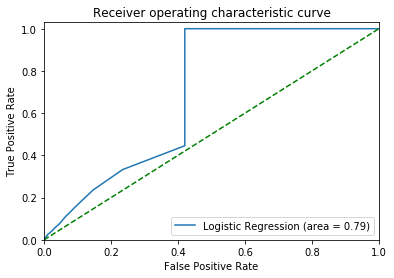

In [72]:
log_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresolds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label = "Logistic Regression (area = %0.2f)" % log_roc_auc)
plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1.03])
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

###  To Do

- Visualize the raw data through graphs and draw inferences.
<br>
- Try different models like random forests and compare the results.
<br>
- Include more meaningful features in the data
<br> 